# FFT Processing

Before we start I highly recommand that you read section [Discrete Fourier Transform](sec-dft) since this section depends on it.

## Short-Time Fourier Transform

To compute the DFT and IDFT using the FFT algorithm in [SuperCollider (SC)](https://supercollider.github.io/), we use the unit generators [FFT](https://doc.sccode.org/Classes/FFT.html) and [IFFT](https://doc.sccode.org/Classes/IFFT.html), respectively.
And because the fast Fourier transform algorithm is so efficient, we can do it in real time!
Therefore, we "work" in frequency space by

1. Transforming the signal into the frequency space using the [FFT](https://doc.sccode.org/Classes/FFT.html) unit generator
2. Manipulating the coefficients as we desire
3. Transforming the signal back to the time domain using the [IFFT](https://doc.sccode.org/Classes/IFFT.html) unit generator

````{admonition} FFT and IFFT Buffers
:name: attention-fft-ifft-sc
:class: attention

[FFT](https://doc.sccode.org/Classes/FFT.html) and [IFFT](https://doc.sccode.org/Classes/IFFT.html) unit generators require a buffer to store the frequency-domain data. 
This buffer must have exactly **one** channel. 
Multichannel buffers are never supported.

To do [FFT](https://doc.sccode.org/Classes/FFT.html) processing on a multichannel signal, provide an array of mono buffers, one for each channel. 
Then, [FFT](https://doc.sccode.org/Classes/FFT.html)/[IFFT](https://doc.sccode.org/Classes/IFFT.html) will perform [multichannel expansion](sec-mce), to process each channel separately.
````

The following example has no effect on the input 'in' since we merely transform the signal and then promptly revert it.

```isc
(
{
    var in, out, chain, freq = 200;
    in = SinOsc.ar(freq);

    chain = FFT(
        buffer: LocalBuf(2048), 
        in: in, 
        hop: 0.5, // offset of te next FFT, rnages from > 0 to <= 1.
        wintype: 0, // -1 triangle, 0 sine, 1 Hann
        active: 1, // 1 active, <= 0 inactive
        winsize: 0 // 0 => equal to the buffer
    ); 	

    // here we could manipulate the coefficients
    chain.inspect; 
    out = IFFT(chain); // inverse FFT
    out;
}.play;
)
```

To process sound SuperCollider has a selection of phase vocoder (PV) unit genertors which are commonly used as in place operators on the [FFT](https://doc.sccode.org/Classes/FFT.html) data.
SuperCollider [phase vocoder](https://doc.sccode.org/Guides/FFT-Overview.html#PV%20and%20FFT%20UGens%20in%20the%20Standard%20Library) is a technique used in computer music to manipulate blocks of spectral data before reconversion.
The process of buffering, windowing, conversion, overlap-add, etc.

In the following example, we basically filter [WhiteNoise](https://doc.sccode.org/Classes/WhiteNoise.html) by randomly setting most coefficients thus frequencies to zero.
Whenever the impulse triggers [PV_RandComb](https://doc.sccode.org/Classes/PV_RandComb.html), the selection of non-zero frequencies changes.
Since the ``windowsize`` determines the lowest frequency we can capture, increasing the buffer size will reduce the pitch of the result.

```isc
(
{
    var in, chain;
    in = WhiteNoise.ar(0.8);
    chain = FFT(LocalBuf(2048), in);
    chain = PV_RandComb(chain, 0.95, Impulse.kr(0.4));
    IFFT(chain)
}.play;
)
```

In [1]:
import IPython.display as ipd

audio_path = '../../sounds/fft-wnoise.mp3'
ipd.Audio(audio_path)

Plotting the [spectrogram](sec-spectrogram) reveals the effect visually.

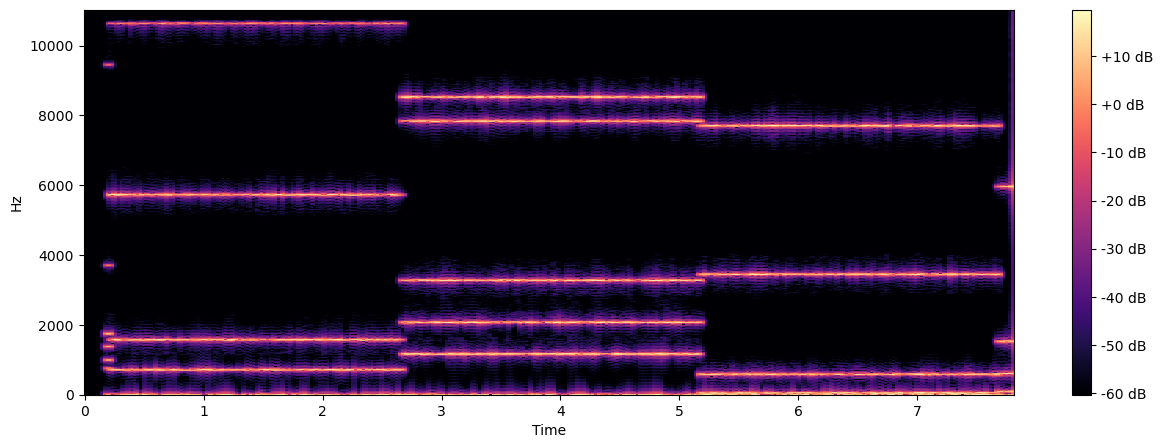

In [2]:
import librosa
import matplotlib.pyplot as plt

x, sr = librosa.load('../../sounds/fft-wnoise.mp3')

hop_length = 512
n_fft = 2048
C = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
S = librosa.amplitude_to_db(abs(C))

plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear');
plt.colorbar(format='%+2.0f dB');

If we want to modify spectral data individually, we can utilize ``pvcollect``.
In the following instance, I simulate [PV_RandComb](https://doc.sccode.org/Classes/PV_RandComb.html) by using a random [Array](https://doc.sccode.org/Classes/Array.html) named ``active`` that contains zeros and ones.
Moreover, the operation 

```isc
index.linexp(b.numFrames, 0, 0.3, 1.0);
``` 

reduces the amplitude of high frequencies.
To infuse movement, I deploy 2048 low-frequency [Pluse](https://doc.sccode.org/Classes/Pluse.html) unit generators.
Since ``active`` is smaller than the number frames/windows, i.e. ``b.numFrames`` I utilize ``wrapAt`` to wrap around.
Consequently, a pattern of active frequencies is repeated.

```isc
(
{
    var in, chain, b, active, g_amp = 14.0;
    b = LocalBuf(2048);
    active = Array.fill(200, {if(1.0.rand > 0.97, 1, 0)});
    in = PinkNoise.ar();
    chain = FFT(b, in);

    chain = chain.pvcollect(b.numFrames, {|mag, phase, bin, index|
        var factor = index.linexp(b.numFrames, 0, 0.3, 1.0);
        var amp = Pulse.kr(
            rrand(3, 20), 
            rrand(0.1, 0.8)).range(0, 0.9) * factor;
            
        [mag*amp*active.wrapAt(index)*g_amp, phase]
    });

    Pan2.ar(IFFT(chain))
}.play;
)
```

In [3]:
audio_path = '../../sounds/fft-pvcollect.mp3'
ipd.Audio(audio_path)

Again, let us look at the [spectrogram](sec-spectrogram):

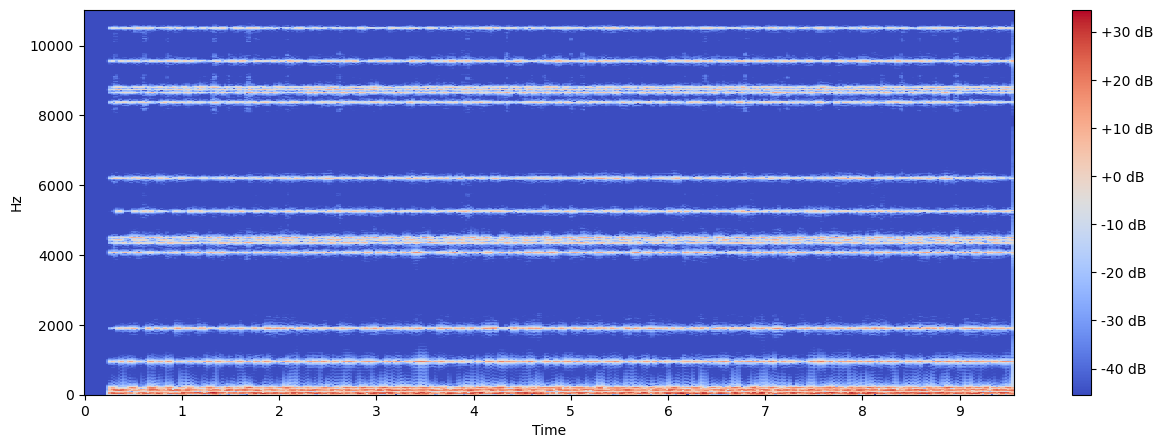

In [4]:
x, sr = librosa.load('../../sounds/fft-pvcollect.mp3')

hop_length = 512
n_fft = 2048
C = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
S = librosa.amplitude_to_db(abs(C))

plt.figure(figsize=(15, 5))
librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear');
plt.colorbar(format='%+2.0f dB');

You might notice the repeating frequncy pattern.

## Mel Frequency Cepstral Coefficients

TODO